In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pyPI as pi
import cv2

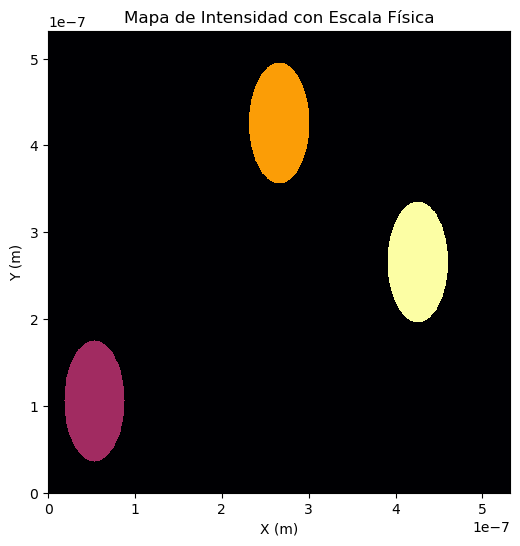

In [156]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros físicos
lambda_ = 532e-9  # Longitud de onda en metros
x_size = 1000  # Número de píxeles en el eje x
y_size = 500   # Número de píxeles en el eje y
diameter = 7e-8  # Diámetro del glóbulo rojo en metros
delta_chi = np.pi/4

# Escalas de conversión de píxeles a metros
x_scale = lambda_ / x_size  # Tamaño de cada píxel en metros en x
y_scale = lambda_ / y_size  # Tamaño de cada píxel en metros en y

# Crear las coordenadas físicas
x_pixels = np.arange(x_size)
y_pixels = np.arange(y_size)
X, Y = np.meshgrid(x_pixels, y_pixels)
X_meters = X * x_scale
Y_meters = Y * y_scale

# Diámetro en píxeles
diameter_pixels = max(5, min(int(diameter / lambda_ * x_size), min(x_size, y_size) // 2))

# Crear la imagen con intensidad de fondo 0 (sample_image)
sample_image = np.full((y_size, x_size), 0, dtype=np.uint8)

# Crear sample con la matriz identidad como fondo (debe ser complejo)
sample = np.full((y_size, x_size, 2, 2), np.eye(2, dtype=np.complex128), dtype=np.complex128)
#sample = np.full((y_size, x_size, 2, 2), np.zeros((2, 2), dtype=np.complex128), dtype=np.complex128)

# Definir posiciones fijas para los glóbulos rojos (en píxeles)
fixed_positions = [(100, 400), (500, 100), (800, 250)]  # (x, y) en píxeles

# Definir intensidades específicas para cada glóbulo rojo en sample_image
intensity_values = [100, 180, 230]  # Valores entre 0 y 255


# Definir matrices específicas para cada glóbulo rojo en sample
globulo_matrices = [
    pi.jones_matrix(delta_chi, 0),        # Glóbulo 1
    pi.jones_matrix(delta_chi, np.pi/5),  # Glóbulo 2
    pi.jones_matrix(delta_chi, np.pi/7)   # Glóbulo 3
]

# Generar los glóbulos rojos con intensidades y matrices definidas
for (center_x, center_y), intensity_value, globulo_matrix in zip(fixed_positions, intensity_values, globulo_matrices):
    y, x = np.ogrid[:y_size, :x_size]
    mask = (x - center_x)**2 + (y - center_y)**2 <= (diameter_pixels // 2) ** 2
    sample_image[mask] = intensity_value  # Asignar intensidad en la imagen
    sample[mask, :, :] = globulo_matrix  # Asignar la matriz específica en sample

# Función para convertir píxeles a metros
def pixel_to_meter(x_pixel, y_pixel):
    x_meter = x_pixel * x_scale
    y_meter = y_pixel * y_scale
    return x_meter, y_meter

# Convertir posiciones de píxeles a metros
physical_positions = [pixel_to_meter(x, y) for x, y in fixed_positions]

# Graficar el mapa de intensidad con escala en metros (sample_image)
plt.figure(figsize=(6, 6))
extent = [0, x_size * x_scale, 0, y_size * y_scale]  # Extender en unidades físicas
plt.imshow(sample_image, cmap='inferno', interpolation='nearest', extent=extent)
plt.title('Mapa de Intensidad con Escala Física')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()


In [157]:
# Definir la matriz objetivo
target_matrix = globulo_matrices[2]

# Encontrar los píxeles donde sample tiene esta matriz
matches = np.all(sample == target_matrix, axis=(2, 3))

# Obtener las coordenadas (y, x) de los píxeles que contienen la matriz objetivo
matching_pixels = np.argwhere(matches)

# Mostrar los píxeles encontrados
sample[matching_pixels[0,0], matching_pixels[0,1]]


array([[0.94486136-0.13311646j, 0.11449657+0.27641917j],
       [0.11449657+0.27641917j, 0.76224542-0.57399032j]])

In [158]:
def create_vector_matrix(E, y_size, x_size):
    E_map = np.empty((y_size, x_size), dtype=object)
    
    for i in range(y_size):
        for j in range(x_size):
            E_map[i, j] = E.copy()
    
    return E_map


In [159]:

E_is = create_vector_matrix(np.array([[1], [1j]]), y_size, x_size)

# Crear Es con la misma forma que Eis
E_s = np.empty_like(E_is, dtype=object)

# Aplicar la operación elemento a elemento
for i in range(sample.shape[0]):
    for j in range(sample.shape[1]):
        E_s[i, j] = sample[i, j] @ E_is[i, j]


In [160]:
E_r = create_vector_matrix(np.array([[1], [-1j]]), y_size, x_size)

k = 2 * np.pi / lambda_  # Número de onda
mu = 0  # Desplazamiento de fase global

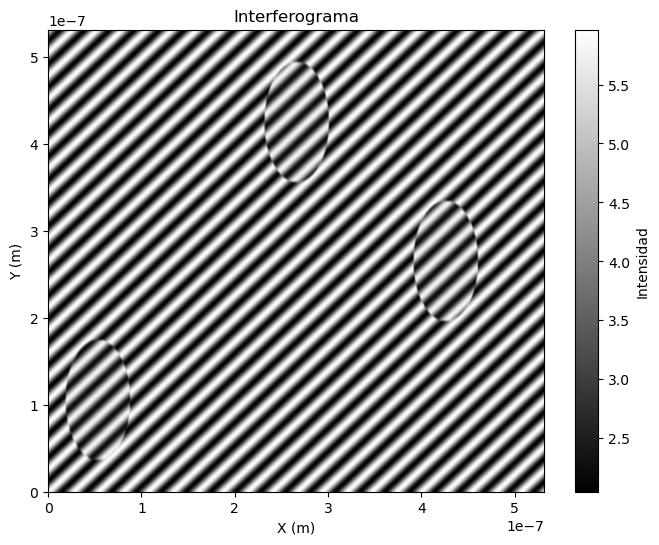

In [161]:
# Convertir E_r y E_s en arreglos NumPy de forma (M, N, 2)
E_r = np.stack([[elem.flatten() for elem in row] for row in E_r])
E_s = np.stack([[elem.flatten() for elem in row] for row in E_s])

# Ahora E_r y E_s tienen la forma correcta y se pueden operar normalmente

# Cálculo de Omega y Psi en cada píxel
Omega = np.sum(np.abs(E_r) ** 2, axis=-1) + np.sum(np.abs(E_s) ** 2, axis=-1)
Psi = np.abs(np.einsum('ijk,ijk->ij', E_r, E_s))

# Cálculo de la fase relativa (vartheta) en cada píxel
numerator = -np.abs(E_r[:, :, 1]) * np.abs(E_s[:, :, 1]) * np.sin(np.angle(E_r[:, :, 1]) - np.angle(E_s[:, :, 1]))
denominator = np.abs(E_r[:, :, 0]) * np.abs(E_s[:, :, 0]) + np.abs(E_r[:, :, 1]) * np.abs(E_s[:, :, 1]) * np.cos(np.angle(E_r[:, :, 1]) - np.angle(E_s[:, :, 1]))
vartheta = np.arctan2(numerator, denominator)

# Modulación de fase para cada píxel considerando X y Y en metros
#zeta = 2 * (k * (X_meters) - vartheta)
n_f = 20
zeta = n_f * (k * (X_meters + Y_meters) - vartheta)
I = Omega + Psi * np.cos(mu + zeta)

# Normalizar la intensidad a escala de 0 a 255
#I_norm = ((I - I.min()) / (I.max() - I.min()) * 255).astype(np.uint8)

# Aplicar desenfoque gaussiano para suavizar las franjas
I_blurred = cv2.GaussianBlur(I, (5, 5), 0)

# Graficar el interferograma
plt.figure(figsize=(8, 6))
extent = [X_meters.min(), X_meters.max(), Y_meters.min(), Y_meters.max()]
plt.imshow(I_blurred, cmap='gray', aspect='auto', extent=extent)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Interferograma")
plt.colorbar(label="Intensidad")
plt.show()
